# 1.5a: Sanity Check Sky Map

This notebook visually confirms that the cluster we identified corresponds to the overdensity in the sky maps.

## The Question

We've done extensive quantitative analysis:
- Identified an overdensity in the sky map (1.3a/1.3b)
- Caught ~20,373 tokens in a spatial bounding box (1.4a)
- Found a tight cluster of 2,212 tokens via adjacency graph (1.4g/1.4h)

But do these correspond to the same structure? Let's visualize all three populations on the same sky map:

- **Background**: All 151,936 tokens (gray, small, translucent)
- **Middle**: The 20,373 overdensity tokens (blue, medium)
- **Foreground**: The 2,212 cluster tokens (red, large, opaque)

If our analysis is correct, the red cluster should appear as a concentrated blob within the blue overdensity region.

## Method

We'll create two visualizations:
1. **Mollweide projection** (latitude vs longitude)
2. **Polar projection** (radius vs longitude)

Both with the three-layer color scheme to show the hierarchical structure.

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# PCA basis (must match 1.3a/1.3b/1.4a)
NORTH_PC = 2
MERIDIAN_PC = 1
EQUINOX_PC = 3

# Visualization
FIGSIZE = (16, 8)
DPI = 200

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Load W and Compute Spherical Coordinates

In [3]:
# Load W
tensor_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(tensor_path)["W"]
W = W_bf16.to(torch.float32)
N, d = W.shape

print(f"Loaded W: {W.shape}")

Loaded W: torch.Size([151936, 2560])


In [4]:
# PCA
print("Computing PCA...")
W_centered = W - W.mean(dim=0)
cov = (W_centered.T @ W_centered) / N
eigenvalues, eigenvectors = torch.linalg.eigh(cov)
idx = torch.argsort(eigenvalues, descending=True)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
print("✓ PCA computed")

Computing PCA...
✓ PCA computed


In [5]:
# Define basis
def get_pc_vector(pcs, index):
    pc_num = abs(index) - 1
    vector = pcs[:, pc_num].clone()
    if index < 0:
        vector = -vector
    return vector

north = get_pc_vector(eigenvectors, NORTH_PC)
meridian = get_pc_vector(eigenvectors, MERIDIAN_PC)
equinox = get_pc_vector(eigenvectors, EQUINOX_PC)

In [6]:
# Spherical coordinates for ALL tokens
print("Computing spherical coordinates for all tokens...")
x = W @ meridian
y = W @ equinox
z = W @ north

r = torch.sqrt(x**2 + y**2 + z**2)
lat_rad = torch.asin(torch.clamp(z / r, -1, 1))
lat_deg = torch.rad2deg(lat_rad)
lon_rad = torch.atan2(y, x)
lon_deg = torch.rad2deg(lon_rad)
print("✓ Spherical coordinates computed")

Computing spherical coordinates for all tokens...
✓ Spherical coordinates computed


## Load Token Populations

In [7]:
print("\nLoading token populations...\n")

# Load overdensity tokens (from 1.4b)
overdensity_path = Path(f"../tensors/{MODEL_NAME}/1.4b_overdensity_distances.safetensors")
overdensity_data = load_file(overdensity_path)
overdensity_token_ids = overdensity_data['spike_token_ids']

print(f"Loaded overdensity tokens: {len(overdensity_token_ids):,}")

# Load cluster tokens (from 1.4h)
cluster_path = Path(f"../tensors/{MODEL_NAME}/1.4h_cluster_tokens.safetensors")
cluster_data = load_file(cluster_path)
cluster_token_ids = cluster_data['cluster_token_ids']

print(f"Loaded cluster tokens: {len(cluster_token_ids):,}")
print()

# Create masks for plotting
overdensity_mask = torch.zeros(N, dtype=torch.bool)
overdensity_mask[overdensity_token_ids] = True

cluster_mask = torch.zeros(N, dtype=torch.bool)
cluster_mask[cluster_token_ids] = True

# Background = everything not in overdensity
background_mask = ~overdensity_mask

print(f"Token populations:")
print(f"  Background: {background_mask.sum():,}")
print(f"  Overdensity: {overdensity_mask.sum():,}")
print(f"  Cluster: {cluster_mask.sum():,}")


Loading token populations...

Loaded overdensity tokens: 20,373
Loaded cluster tokens: 2,212

Token populations:
  Background: 131,563
  Overdensity: 20,373
  Cluster: 2,212


## Mollweide Sky Map


Creating Mollweide sky map...



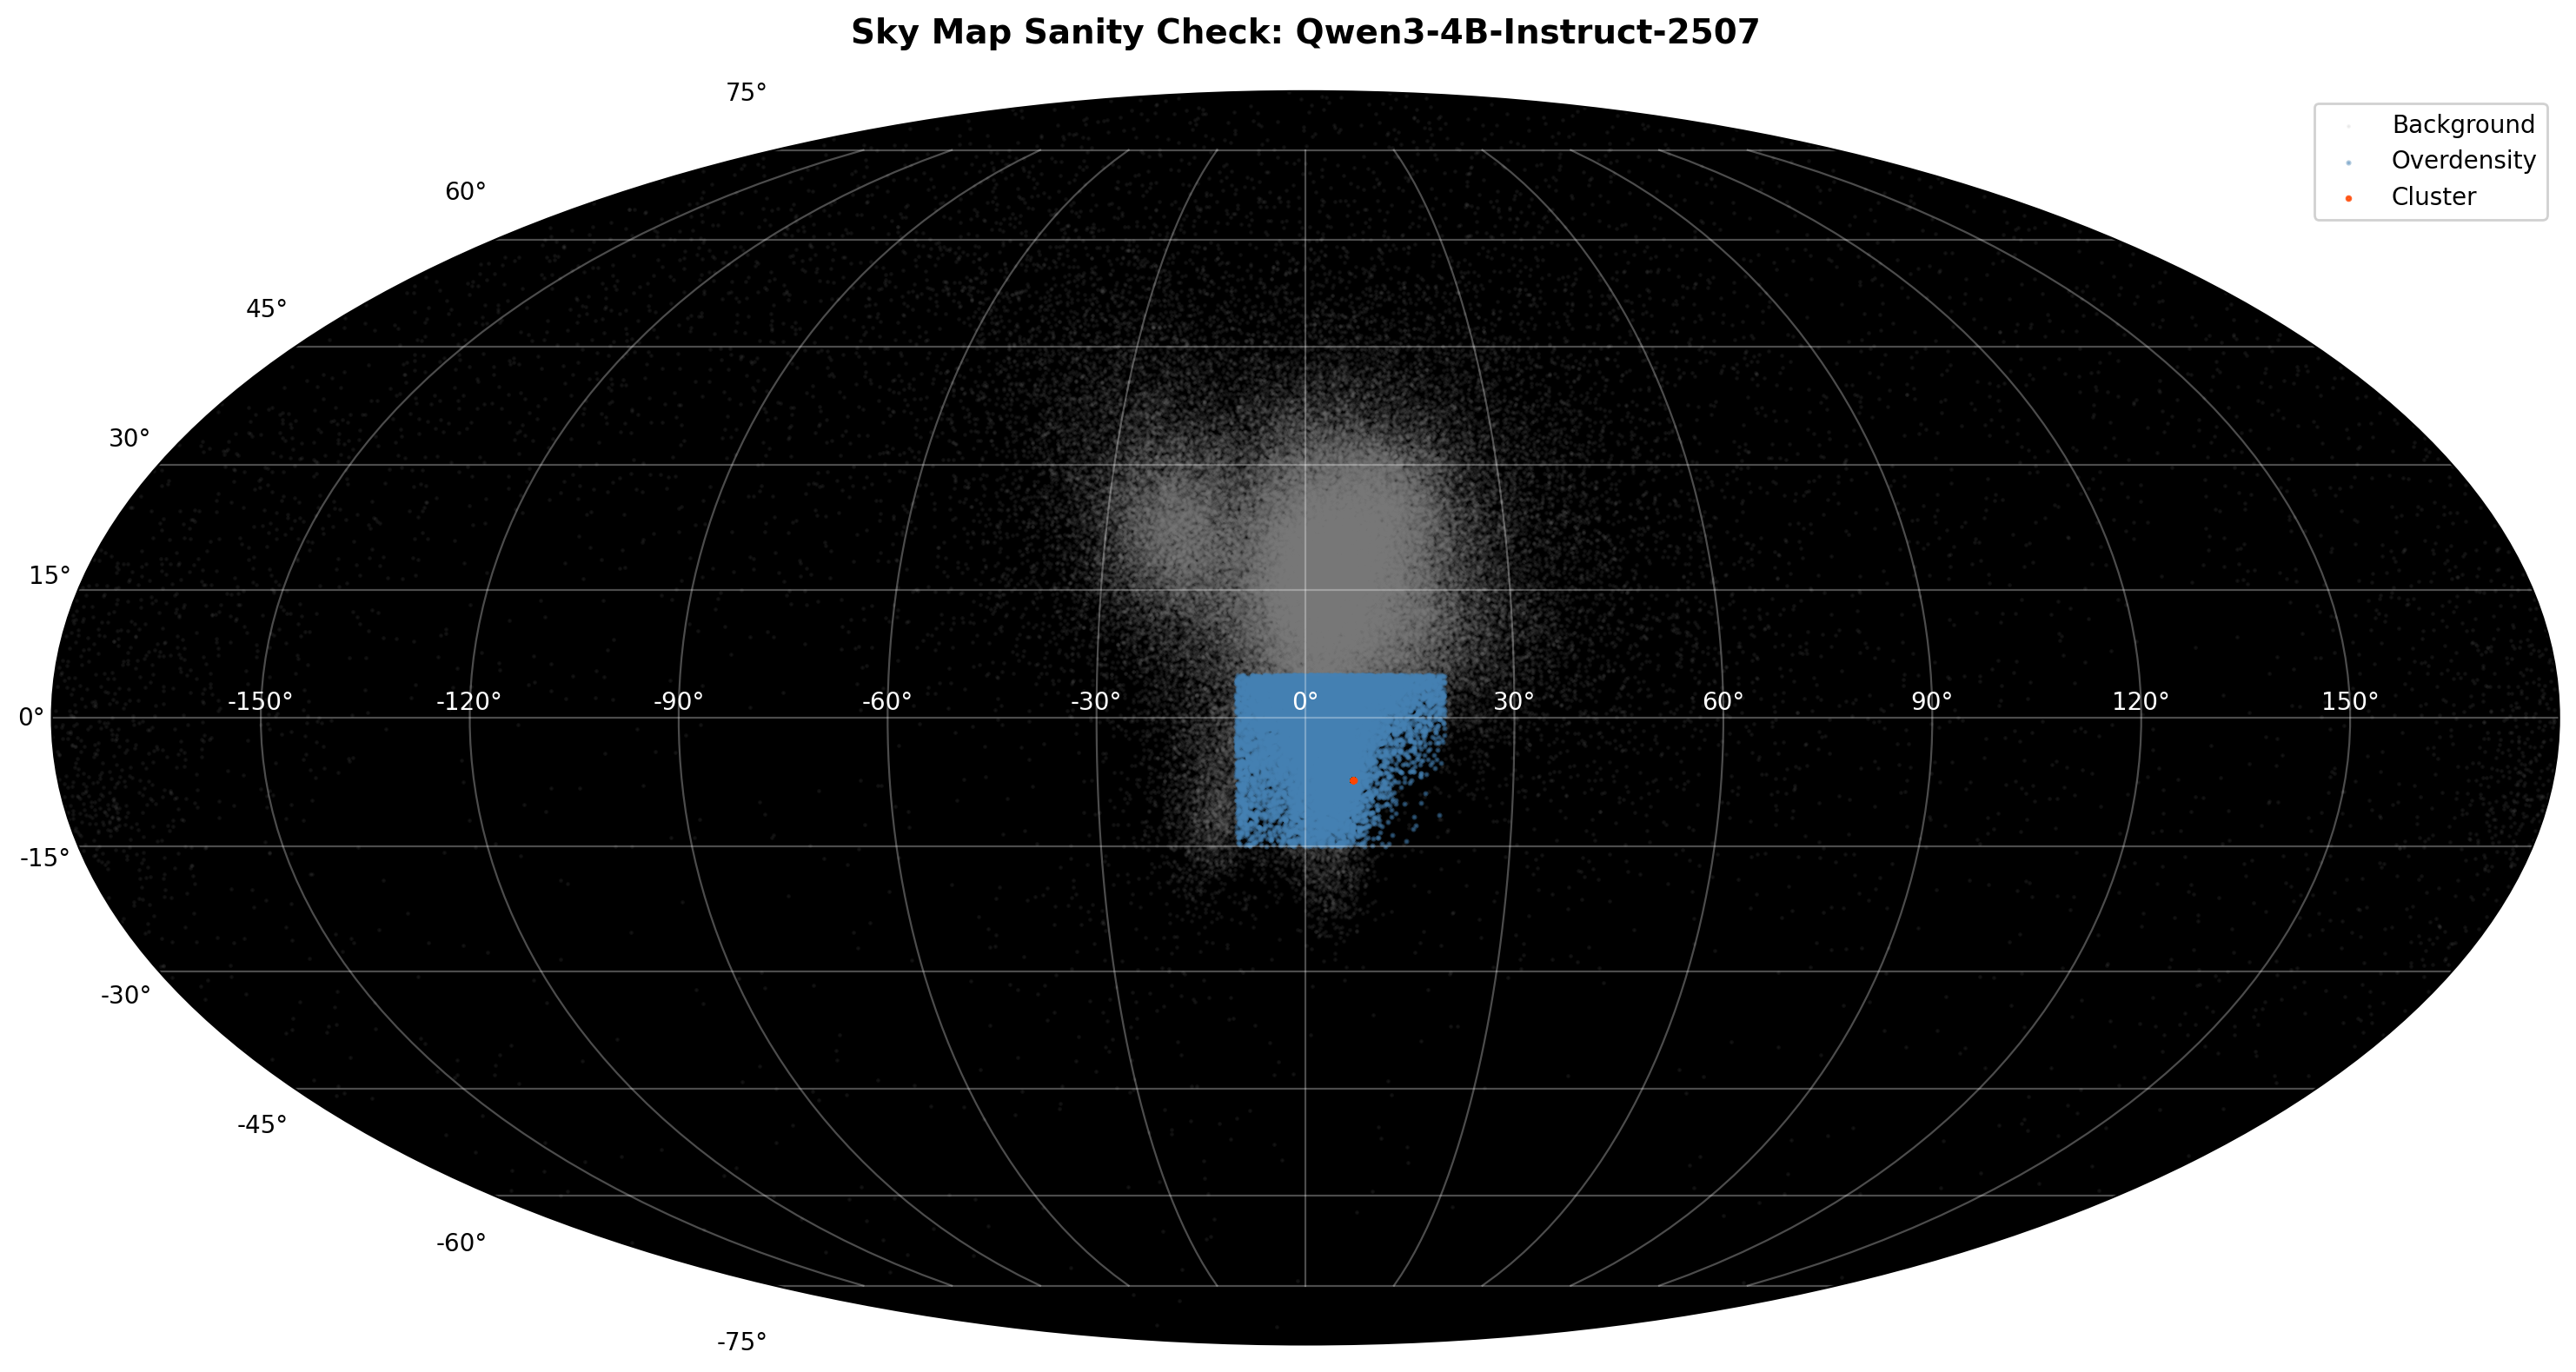

✓ Mollweide sky map complete


In [8]:
print("\nCreating Mollweide sky map...\n")

# Convert to numpy and radians
lon_plot = lon_deg.numpy()
lat_plot = lat_deg.numpy()
lon_rad = np.deg2rad(lon_plot)
lat_rad = np.deg2rad(lat_plot)

# Create figure
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
ax = fig.add_subplot(111, projection='mollweide')
ax.set_facecolor('black')

# Plot in layers (background to foreground)
# Layer 1: Background tokens (gray, small, very translucent)
ax.scatter(lon_rad[background_mask], lat_rad[background_mask], 
           s=0.5, alpha=0.1, c='gray', rasterized=True, label='Background')

# Layer 2: Overdensity tokens (blue, medium)
ax.scatter(lon_rad[overdensity_mask], lat_rad[overdensity_mask], 
           s=1.5, alpha=0.4, c='steelblue', rasterized=True, label='Overdensity')

# Layer 3: Cluster tokens (red, large, opaque)
ax.scatter(lon_rad[cluster_mask], lat_rad[cluster_mask], 
           s=3, alpha=0.8, c='orangered', rasterized=True, label='Cluster')

# Formatting
ax.grid(True, alpha=0.3, color='white')
ax.set_title(f'Sky Map Sanity Check: {MODEL_NAME}', 
             color='black', pad=20, fontsize=14, fontweight='bold')
ax.legend(loc='upper right', framealpha=0.9)

# Set tick colors
for label in ax.get_xticklabels():
    label.set_color('white')
for label in ax.get_yticklabels():
    label.set_color('black')

plt.tight_layout()
plt.show()

print("✓ Mollweide sky map complete")

## Polar (Equatorial) Map


Creating polar equatorial map...



/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_37198/1813354508.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(d)}°' for d in tick_degs])


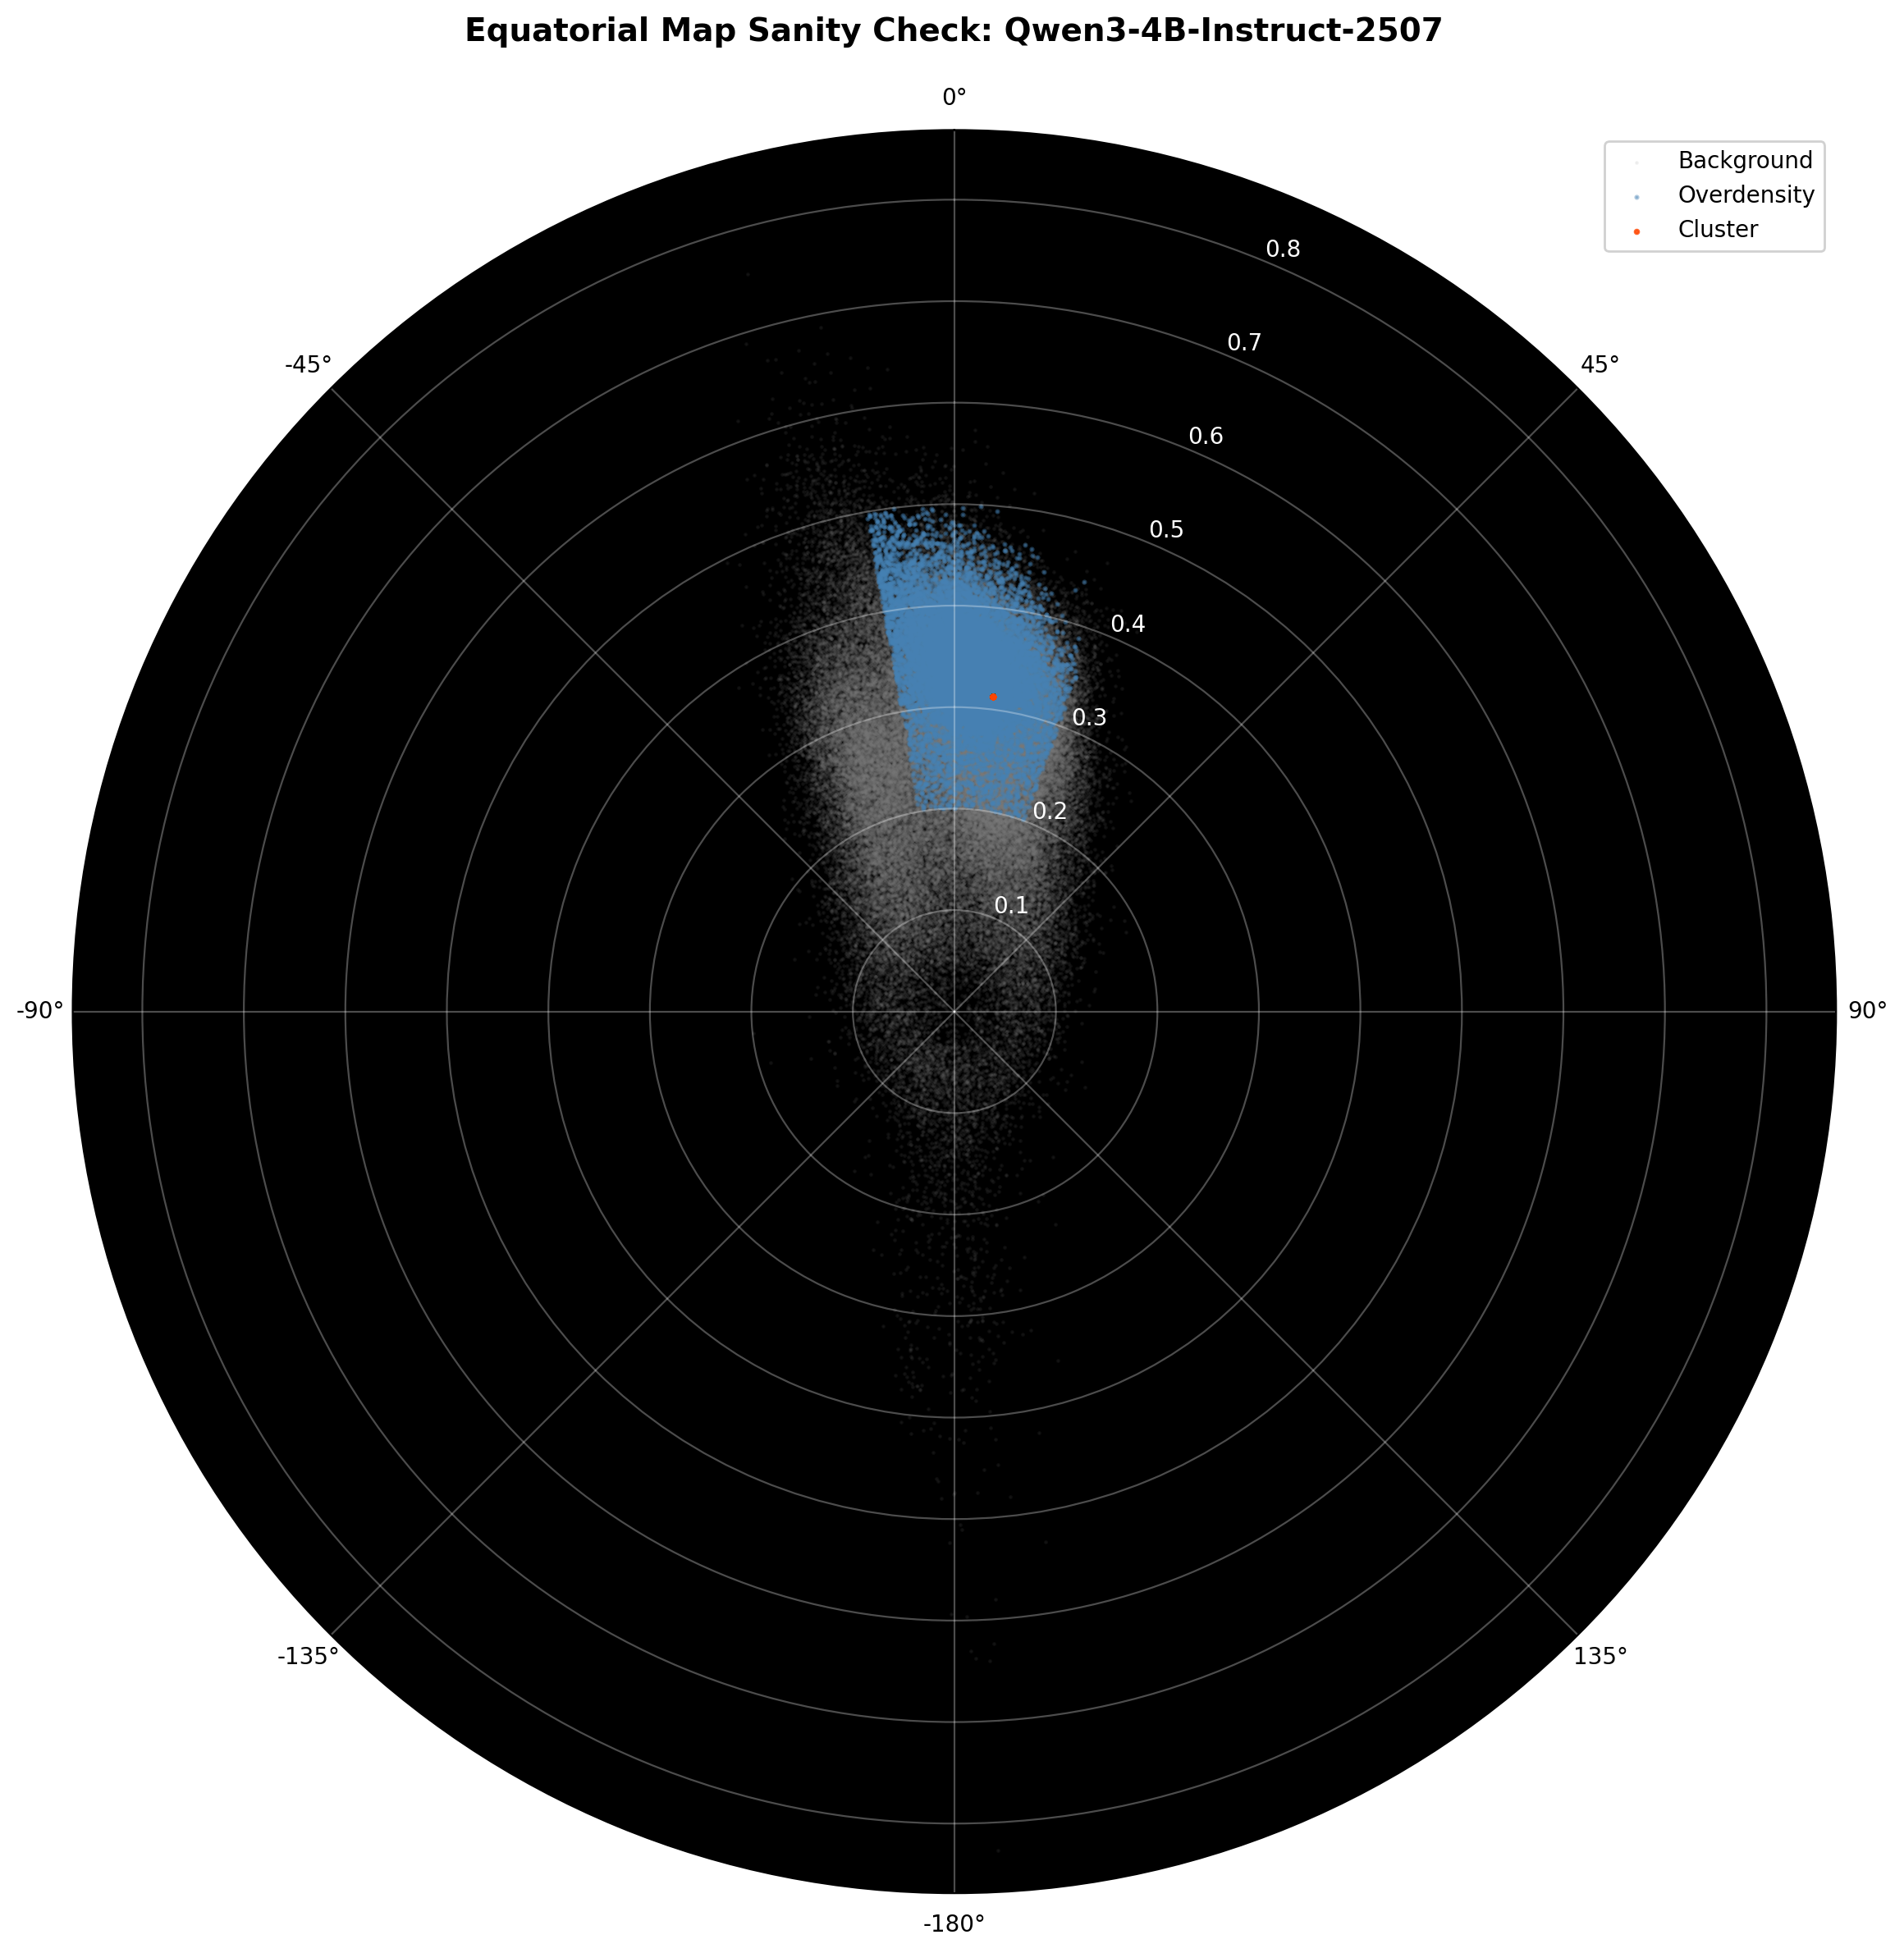

✓ Polar equatorial map complete


In [9]:
print("\nCreating polar equatorial map...\n")

# Get radius values
r_plot = r.numpy()

# Create figure
fig = plt.figure(figsize=(12, 12), dpi=DPI)
ax = fig.add_subplot(111, projection='polar')
ax.set_facecolor('black')

# Plot in layers (background to foreground)
# Layer 1: Background tokens (gray, small, very translucent)
ax.scatter(lon_rad[background_mask], r_plot[background_mask], 
           s=0.5, alpha=0.1, c='gray', rasterized=True, label='Background')

# Layer 2: Overdensity tokens (blue, medium)
ax.scatter(lon_rad[overdensity_mask], r_plot[overdensity_mask], 
           s=1.5, alpha=0.4, c='steelblue', rasterized=True, label='Overdensity')

# Layer 3: Cluster tokens (red, large, opaque)
ax.scatter(lon_rad[cluster_mask], r_plot[cluster_mask], 
           s=3, alpha=0.8, c='orangered', rasterized=True, label='Cluster')

# Formatting
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.grid(True, alpha=0.3, color='white')
ax.set_title(f'Equatorial Map Sanity Check: {MODEL_NAME}', 
             color='black', pad=20, fontsize=14, fontweight='bold')
ax.legend(loc='upper right', framealpha=0.9)

# Get the default tick positions (in radians)
tick_locs = ax.get_xticks()

# Convert each tick from radians to degrees
tick_degs = np.rad2deg(tick_locs)

# Wrap to -180 to 180 range
tick_degs = ((tick_degs + 180) % 360) - 180

# Set the labels (but keep original positions)
ax.set_xticklabels([f'{int(d)}°' for d in tick_degs])

# Set tick colors
for label in ax.get_xticklabels():
    label.set_color('black')
for label in ax.get_yticklabels():
    label.set_color('white')

plt.tight_layout()
plt.show()

print("✓ Polar equatorial map complete")

## Observations

Look for:

**Spatial coherence:**
- Does the red cluster form a concentrated blob?
- Is it contained within the blue overdensity region?
- Are there stray red points far from the main cluster?

**Location confirmation:**
- Does the cluster appear at the coordinates we identified in 1.3a?
- Does it match the low-norm spike location from 1.2a?
- Is the radial position consistent (~0.2-0.5 range)?

**Structure validation:**
- Does the blue overdensity contain ~20,373 tokens as expected?
- Does the red cluster contain exactly 2,212 tokens?
- Is there visible separation (void) between cluster and ambient tokens?

If all these match, our analysis is validated: we've successfully identified and isolated a geometrically coherent cluster within the overdensity.